Experiment 1

In [1]:
!sudo apt update
!sudo apt install openjdk-17-jdk -y
!echo 'export JAVA_HOME=$(dirname $(dirname $(readlink -f $(which java))))' >> ~/.bashrc
!source ~/.bashrc

!pip install konlpy

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
38 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as re

In [2]:
!pip install gensim==4.3.2

# 의존성 연결을 위해 다운그레이드를 진행합니다.
!pip install scipy==1.12.0 numpy==1.26.2

In [3]:
!unzip '/content/synopsis.zip'

Archive:  /content/synopsis.zip
  inflating: synopsis.txt            
  inflating: synopsis_SF.txt         
  inflating: synopsis_action.txt     
  inflating: synopsis_adult.txt      
  inflating: synopsis_adventure.txt  
  inflating: synopsis_animation.txt  
  inflating: synopsis_art.txt        
  inflating: synopsis_comedy.txt     
  inflating: synopsis_crime.txt      
  inflating: synopsis_documentary.txt  
  inflating: synopsis_drama.txt      
  inflating: synopsis_etc.txt        
  inflating: synopsis_family.txt     
  inflating: synopsis_fantasy.txt    
  inflating: synopsis_gen.txt        
  inflating: synopsis_historical.txt  
  inflating: synopsis_horror.txt     
  inflating: synopsis_musical.txt    
  inflating: synopsis_mystery.txt    
  inflating: synopsis_romance.txt    
  inflating: synopsis_show.txt       
  inflating: synopsis_thriller.txt   
  inflating: synopsis_war.txt        
  inflating: synopsis_western.txt    


In [4]:
import os, re
DATA_DIR = "/content"

genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt',
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt',
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt',
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt',
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']

genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
              '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']


genre_files = {g: os.path.join(DATA_DIR, f) for g, f in zip(genre_name, genre_txt)}
for g, p in genre_files.items():
    if not os.path.exists(p): print("⚠️ there is no file:", p)
len(genre_files), list(genre_files.items())[:3]


(21,
 [('SF', '/content/synopsis_SF.txt'),
  ('가족', '/content/synopsis_family.txt'),
  ('공연', '/content/synopsis_show.txt')])

In [5]:
def get_tokenizer():
    try:
        from konlpy.tag import Okt
        okt = Okt()
        def tokenize_ko_nouns(text):
            return [w for w, pos in okt.pos(text, norm=True, stem=True) if pos == "Noun"]
        return tokenize_ko_nouns, "OKT"
    except Exception:
        def tokenize_ko_nouns(text):
            toks = re.findall(r"[가-힣A-Za-z0-9]+", text)
            return [t for t in toks if len(t) >= 2]
        return tokenize_ko_nouns, "REGEX"

tokenize, tok_name = get_tokenizer()
print("Tokenizer:", tok_name)


Tokenizer: OKT


In [6]:
genre_texts = {}
for g, path in genre_files.items():
    with open(path, "r", encoding="utf-8") as f:
        genre_texts[g] = f.read()

genre_tokens = {g: tokenize(txt) for g, txt in genre_texts.items()}

genre_docs_for_tfidf = {g: " ".join(toks) for g, toks in genre_tokens.items()}
w2v_corpus = list(genre_tokens.values())


In [7]:
from gensim.models import Word2Vec
model = Word2Vec(
    sentences=w2v_corpus,
    vector_size=100, window=5, min_count=3,
    sg=0, seed=42, workers=4, epochs=15
)

def show_sim(seed_words, topn=5):
    for w in seed_words:
        if w in model.wv:
            print(f"{w} →", [x for x,_ in model.wv.most_similar(w, topn=topn)])

show_sim(["예술","오락","흥행","작품"], topn=5)


예술 → ['폴란드', '결합', '영화로', '실화', '바그너']
오락 → ['벽', '신비', '다리', '업', '크기']
흥행 → ['라이브', '이완', '혁권', '발표', '베리']
작품 → ['매체', '영화', '이미지', '에세이', '감독']


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from collections import Counter

TOP_N  = 200
FINAL_K = 60

vectorizer = TfidfVectorizer(min_df=3, max_df=0.95)
X = vectorizer.fit_transform([genre_docs_for_tfidf[g] for g in genre_name])
vocab = np.array(vectorizer.get_feature_names_out())
tfidf_mat = X.toarray()
word2idx = {w:i for i,w in enumerate(vocab)}

genre_top = {}
for i, g in enumerate(genre_name):
    row = tfidf_mat[i]
    idx = np.argsort(row)[::-1][:TOP_N]
    words = [(vocab[j], row[j]) for j in idx if row[j] > 0]
    genre_top[g] = words

word_in_genres = Counter()
for g,lst in genre_top.items():
    for w,_ in lst: word_in_genres[w] += 1

genre_unique = {g: [(w,s) for w,s in lst if word_in_genres[w]==1] for g,lst in genre_top.items()}

def spec_score(gi, w):
    j = word2idx.get(w, None)
    if j is None: return -1e9
    val = tfidf_mat[gi, j]
    other = np.delete(tfidf_mat[:, j], gi)
    return val - (other.mean() if other.size else 0.0)

genre_attributes = {}
for i,g in enumerate(genre_name):
    uniq = [w for w,_ in genre_unique[g]]
    if len(uniq) < FINAL_K:
        cand = [w for w,_ in genre_top[g] if w not in uniq]
        cand = sorted(cand, key=lambda w: spec_score(i,w), reverse=True)
        uniq += cand[:max(0, FINAL_K-len(uniq))]
    else:
        uniq = uniq[:FINAL_K]
    uniq = [w for w in uniq if w in model.wv.key_to_index]
    genre_attributes[g] = uniq

for g in genre_name:
    print(g, len(genre_attributes[g]), genre_attributes[g][:8])


SF 60 ['외계', '시스템', '스타크', '리플리', '수퍼맨', '물체', '진화', '수트']
가족 60 ['낙타', '동구', '미아', '펠리칸', '케이시', '혜지', '테리', '손녀']
공연 60 ['실황', '올레', '프레', '베르디', '콘서트', '백작부인', '반니', '아리아']
공포(호러) 60 ['악령', '캠핑', '정신병원', '레드', '에이미', '심령', '두운', '호러']
기타 60 ['뉴미디어', '상영작', '메트로', '실험영화', '광주', '프라이드', '공사', '독도']
다큐멘터리 60 ['투쟁', '인디다큐페스티발', '문화', '지난', '당시', '등반', '활동', '인권영화제']
드라마 60 ['살의', '포기', '의지', '아시아', '아픔', '하루하루', '청춘', '보기']
멜로로맨스 60 ['형부', '미연', '펜션', '옆집', '수진', '하숙집', '주희', '준석']
뮤지컬 60 ['충무로', '바흐', '모도', '팬텀', '크리스틴', '라훌', '서영은', '파두']
미스터리 60 ['방독면', '몰카', '홈즈', '한나', '동식', '승호', '프리드', '동영상']
범죄 60 ['파푸아', '금고', '도미', '사기꾼', '범행', '카시우스', '은행강도', '수감']
사극 60 ['조선', '윤서', '양반', '정조', '독립군', '대호', '백성', '김민']
서부극(웨스턴) 60 ['서부', '보안관', '카우보이', '헨리', '무법자', '프린트', '현상금', '버질']
성인물(에로) 60 ['유이', '욕구불만', '성관계', '유코', '유키', '카즈야', '카나', '애무']
스릴러 60 ['영훈', '피해자', '감금', '혜영', '강간', '명훈', '마틴', '콘로']
애니메이션 60 ['인디애니페스트', '만화', '고고', '펭귄', '코리아', '임팩트', '마트', '토끼']
액션 60 ['무술', '액션', '제거',

In [19]:
ART_PATH = "/content/synopsis_art.txt"
GEN_PATH = "/content/synopsis_gen.txt"
with open(ART_PATH, "r", encoding="utf-8") as f:
    art_text = f.read()
with open(GEN_PATH, "r", encoding="utf-8") as f:
    gen_text = f.read()

art_doc = " ".join(tokenize(art_text))
gen_doc = " ".join(tokenize(gen_text))


In [20]:
docs = [art_doc, gen_doc]
n_doc = len(docs)

safe_min_df = 1
safe_max_df = n_doc

from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(
    min_df=safe_min_df,
    max_df=safe_max_df,
    # optional:
    sublinear_tf=True,
    norm="l2"
)

X = vec.fit_transform(docs).toarray()
vocab = vec.get_feature_names_out()

if X.shape[1] == 0:
    vec = TfidfVectorizer(min_df=1, max_df=1.0)
    X = vec.fit_transform(docs).toarray()
    vocab = vec.get_feature_names_out()

if X.shape[1] == 0:
    raise ValueError("После токенизации art/gen пусты. Проверь содержимое файлов и токенизацию.")


In [21]:
art_scores = X[0] - X[1]
gen_scores = X[1] - X[0]

K = 80
art_rank = art_scores.argsort()[::-1]
gen_rank = gen_scores.argsort()[::-1]

raw_art = [vocab[i] for i in art_rank if art_scores[i] > 0][:K]
raw_gen = [vocab[i] for i in gen_rank if gen_scores[i] > 0][:K]

art_set = set(raw_art)
gen_set = set(raw_gen)
overlap = art_set & gen_set
art_set -= overlap
gen_set -= overlap


if not art_set or not gen_set:
    raw_art2 = [vocab[i] for i in art_rank][:K]
    raw_gen2 = [vocab[i] for i in gen_rank][:K]
    art_set = set(raw_art2)
    gen_set = set(raw_gen2)

art_words = [w for w in art_set if w in model.wv.key_to_index]
gen_words = [w for w in gen_set if w in model.wv.key_to_index]


if not art_words or not gen_words:
    seed_art = ["예술","작품성","미학","실험성","작가주의"]
    seed_gen = ["상업","오락","대중성","흥행","시장성"]

    def expand(seed, topn=20):
        out = set()
        for s in seed:
            if s in model.wv:
                out.update([w for w,_ in model.wv.most_similar(s, topn=topn)])
        return list(out)

    if not art_words:
        art_words = [w for w in expand(seed_art) if w in model.wv.key_to_index][:60]
    if not gen_words:
        gen_words = [w for w in expand(seed_gen) if w in model.wv.key_to_index][:60]


M = min(len(art_words), len(gen_words), 60)
target_art_words = art_words[:M]
target_gen_words = gen_words[:M]

print("targets:", len(target_art_words), len(target_gen_words))
print("art sample:", target_art_words[:15])
print("gen sample:", target_gen_words[:15])


targets: 60 60
art sample: ['비랄', '무쉬', '아틸리오', '장경', '거칠마루', '거미숲', '토미카', '카포티', '구구', '가위눌림', '크리스티아노', '불찰', '승업', '한대수', '창국']
gen sample: ['미치루', '곰퉁', '아시아나', '테드', '엽기', '소스', '건축사', '퍼니퍼', '성현', '스와핑', '삼순', '전복', '상제', '소비', '과자']


In [22]:

X_targets = np.array([model.wv[w] for w in target_art_words if w in model.wv.key_to_index])
Y_targets = np.array([model.wv[w] for w in target_gen_words if w in model.wv.key_to_index])

print("ART words total:", len(target_art_words), "in w2v:", len(X_targets))
print("GEN words total:", len(target_gen_words), "in w2v:", len(Y_targets))
assert len(X_targets) >= 10 and len(Y_targets) >= 10, "not enough words in w2v"


ART words total: 60 in w2v: 60
GEN words total: 60 in w2v: 60


In [23]:
genre_attr_vecs = {
    g: np.array([model.wv[w] for w in genre_attributes[g] if w in model.wv.key_to_index])
    for g in genre_name
}


In [24]:
def cos_sim_vec_vs_mat(vec, mat):
    # vec: (d,), mat: (k,d) -> (k,)
    if mat.size == 0:
        return np.array([])
    num = mat @ vec
    den = np.linalg.norm(mat, axis=1) * np.linalg.norm(vec)
    den = np.maximum(den, 1e-12)
    return num / den

def s_wrt_sets(W, A, B):
    out = []
    for w in W:
        cA = cos_sim_vec_vs_mat(w, A)
        cB = cos_sim_vec_vs_mat(w, B)
        mA = np.mean(cA) if cA.size else 0.0
        mB = np.mean(cB) if cB.size else 0.0
        out.append(mA - mB)
    return np.array(out)

def weat_effect_size(X, Y, A, B):
    sX = s_wrt_sets(X, A, B)
    sY = s_wrt_sets(Y, A, B)
    num = np.mean(sX) - np.mean(sY)
    den = np.std(np.concatenate([sX, sY], axis=0), ddof=1)
    return num / max(den, 1e-12)

def weat_permutation_test(X, Y, A, B, n_perm=2000, rng=None):
    rng = np.random.default_rng(42) if rng is None else rng
    XY = np.concatenate([X, Y], axis=0)
    nX = len(X)
    observed = weat_effect_size(X, Y, A, B)
    count = 0
    for _ in range(n_perm):
        rng.shuffle(XY)
        Xp = XY[:nX]
        Yp = XY[nX:]
        stat = weat_effect_size(Xp, Yp, A, B)
        if abs(stat) >= abs(observed):
            count += 1
    p_value = (count + 1) / (n_perm + 1)
    return observed, p_value


In [25]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, scipy
def rest_attr_vecs(except_g):
    mats = [mat for g, mat in genre_attr_vecs.items() if g != except_g and mat.size]
    return np.concatenate(mats, axis=0) if mats else np.empty((0, model.vector_size))

rows = []
for g in genre_name:
    A = genre_attr_vecs[g]
    B = rest_attr_vecs(g)
    if A.size == 0 or B.size == 0:
        eff, p = 0.0, 1.0
    else:
        eff, p = weat_permutation_test(X_targets, Y_targets, A, B, n_perm=2000)
    rows.append({"genre": g, "weat_effect": eff, "p_value": p})

df_weat = pd.DataFrame(rows).sort_values("weat_effect", ascending=False)
display(df_weat.head(10))


,genre,weat_effect,p_value
6,드라마,0.778035,0.000500
14,스릴러,0.707539,0.001000
12,서부극(웨스턴),0.683683,0.000500
4,기타,0.594860,0.001000
9,미스터리,0.531952,0.002499
15,애니메이션,0.508380,0.004498
10,범죄,0.490190,0.006497
7,멜로로맨스,0.392282,0.033983
8,뮤지컬,0.296451,0.107446
13,성인물(에로),0.204480,0.255372


In [31]:
!apt-get update -qq
!apt-get install -qq fonts-nanum
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


/tmp/ipython-input-2860805243.py:12: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


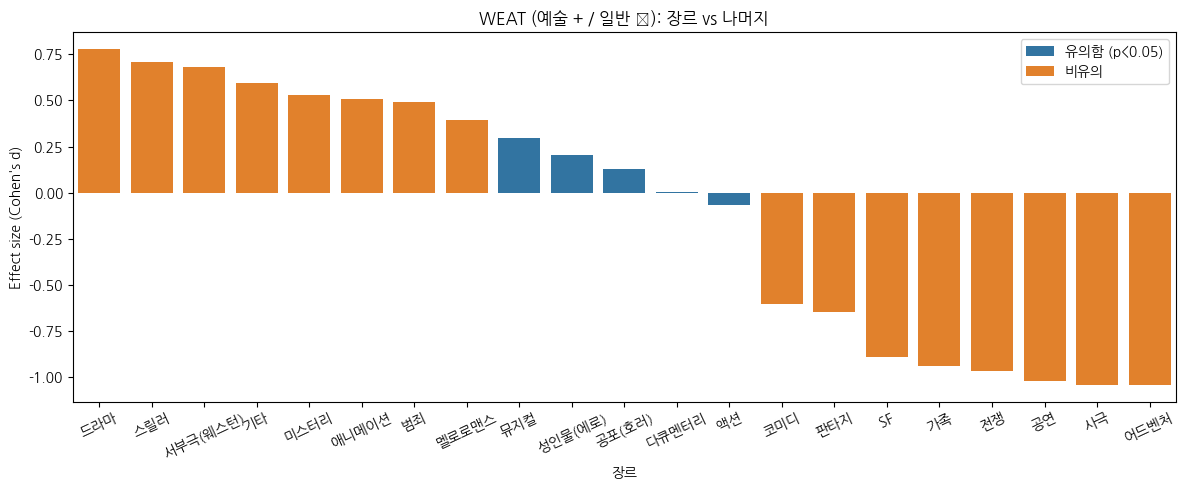

In [32]:
plt.figure(figsize=(12, 5))
ax = sns.barplot(
    data=df_weat,
    x="genre", y="weat_effect",
    hue=(df_weat["p_value"] < 0.05)
)
plt.title("WEAT (예술 + / 일반 −): 장르 vs 나머지")
plt.xlabel("장르"); plt.ylabel("Effect size (Cohen's d)")
plt.xticks(rotation=25)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["유의함 (p<0.05)", "비유의"], title="")
plt.tight_layout()
plt.show()


,genre,aff_art,aff_gen,diff
4,기타,0.144605,0.530538,-0.385932
6,드라마,0.156376,0.553620,-0.397245
14,스릴러,0.160598,0.563997,-0.403399
15,애니메이션,0.162294,0.585912,-0.423617
7,멜로로맨스,0.172093,0.601620,-0.429527
9,미스터리,0.171221,0.605612,-0.434391
10,범죄,0.166354,0.600905,-0.434551
12,서부극(웨스턴),0.170095,0.607040,-0.436945
13,성인물(에로),0.177956,0.615871,-0.437915
3,공포(호러),0.177453,0.620990,-0.443536


/tmp/ipython-input-2763684465.py:28: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


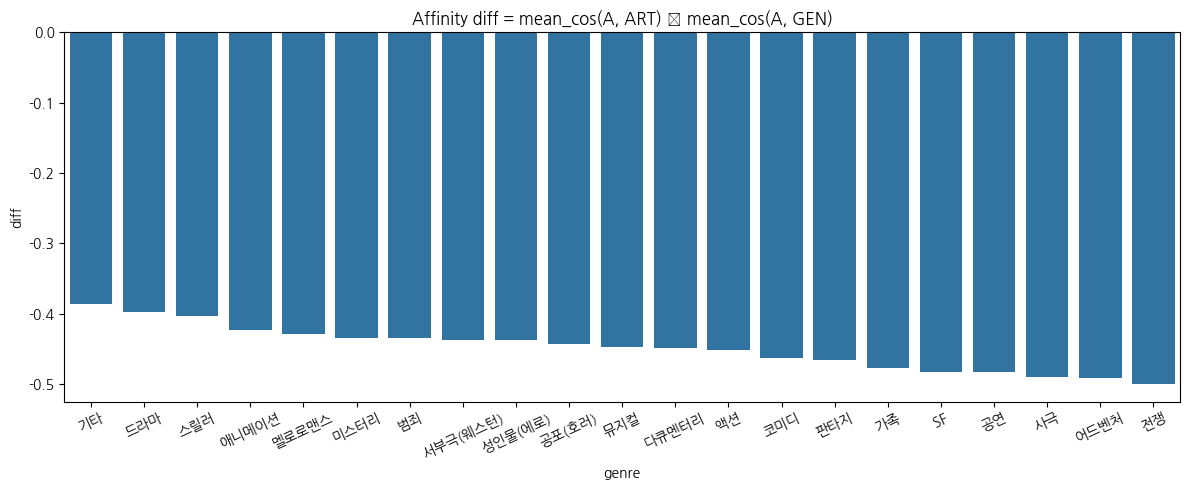

In [33]:
def cos_sim_vec_vs_mat(vec, mat):
    if mat.size == 0: return np.array([])
    num = mat @ vec
    den = np.linalg.norm(mat, axis=1) * np.linalg.norm(vec)
    return num / np.maximum(den, 1e-12)

def mean_cos_to_set(A, T):
    vals = []
    for a in A:
        c = cos_sim_vec_vs_mat(a, T)
        if c.size: vals.append(c.mean())
    return float(np.mean(vals)) if vals else 0.0

rows2 = []
for g in genre_name:
    A = genre_attr_vecs[g]
    aff_art = mean_cos_to_set(A, X_targets)
    aff_gen = mean_cos_to_set(A, Y_targets)
    rows2.append({"genre": g, "aff_art": aff_art, "aff_gen": aff_gen, "diff": aff_art - aff_gen})

df_aff = pd.DataFrame(rows2).sort_values("diff", ascending=False)
display(df_aff.head(10))

plt.figure(figsize=(12,5))
sns.barplot(data=df_aff, x="genre", y="diff")
plt.title("Affinity diff = mean_cos(A, ART) − mean_cos(A, GEN)")
plt.xticks(rotation=25)
plt.tight_layout(); plt.show()


In [34]:
def word_affinity(word):
    if word not in model.wv: return None
    v = model.wv[word]
    a = cos_sim_vec_vs_mat(v, X_targets).mean() if len(X_targets) else 0.0
    g = cos_sim_vec_vs_mat(v, Y_targets).mean() if len(Y_targets) else 0.0
    return a, g, a-g

tables = []
TOP_K = 15  # сколько показывать
for g in genre_name:
    words = genre_attributes[g]
    tmp = []
    for w in words:
        aff = word_affinity(w)
        if aff is None: continue
        a, b, d = aff
        tmp.append((w, a, b, d))
    tmp = sorted(tmp, key=lambda x: x[3], reverse=True)
    tables.append((g, tmp[:TOP_K], tmp[-TOP_K:]))

for g, top_pos, top_neg in tables:
    print(f"\n=== {g} | top +ART ===")
    for w,a,b,d in top_pos: print(f"{w:>12s} | diff={d:.3f} (art={a:.3f}, gen={b:.3f})")
    print(f"=== {g} | top +GEN ===")
    for w,a,b,d in reversed(top_neg): print(f"{w:>12s} | diff={d:.3f} (art={a:.3f}, gen={b:.3f})")



=== SF | top +ART ===
        어니스트 | diff=-0.376 (art=0.144, gen=0.520)
         핵전쟁 | diff=-0.380 (art=0.160, gen=0.540)
          멸망 | diff=-0.394 (art=0.170, gen=0.564)
          가상 | diff=-0.409 (art=0.169, gen=0.578)
          재앙 | diff=-0.449 (art=0.187, gen=0.635)
         플래시 | diff=-0.455 (art=0.189, gen=0.645)
          외계 | diff=-0.459 (art=0.183, gen=0.642)
        괴생명체 | diff=-0.464 (art=0.188, gen=0.652)
          도니 | diff=-0.468 (art=0.191, gen=0.659)
          사태 | diff=-0.469 (art=0.177, gen=0.646)
          섹터 | diff=-0.471 (art=0.187, gen=0.658)
        돌연변이 | diff=-0.473 (art=0.186, gen=0.659)
          진화 | diff=-0.473 (art=0.185, gen=0.658)
         생물체 | diff=-0.474 (art=0.190, gen=0.663)
         클라크 | diff=-0.475 (art=0.195, gen=0.671)
=== SF | top +GEN ===
        타임머신 | diff=-0.514 (art=0.199, gen=0.713)
         유전자 | diff=-0.514 (art=0.200, gen=0.713)
          법안 | diff=-0.513 (art=0.201, gen=0.714)
          화산 | diff=-0.511 (art=0.195, gen=0.706)
     

Experiment 2

In [38]:
seed_art = ["예술", "작품성", "미학", "실험성", "작가주의", "독립영화", "예술영화", "영상미"]
seed_gen = ["상업", "오락", "대중성", "흥행", "블록버스터", "시장성", "스펙터클", "장르영화"]


In [39]:

def is_korean(w):
    return bool(re.fullmatch(r"[가-힣]{2,}", w))

A0 = np.array([model.wv[w] for w in seed_art if w in model.wv])
G0 = np.array([model.wv[w] for w in seed_gen if w in model.wv])
a_cent = A0.mean(axis=0)
g_cent = G0.mean(axis=0)

def cos(u,v):
    nu = np.linalg.norm(u); nv = np.linalg.norm(v)
    if nu<1e-12 or nv<1e-12: return 0.0
    return float(np.dot(u,v)/(nu*nv))

scores = []
for w in model.wv.key_to_index.keys():
    if not is_korean(w):
        continue
    v = model.wv[w]
    s = cos(v, a_cent) - cos(v, g_cent)
    scores.append((w, s))

scores.sort(key=lambda x: x[1], reverse=True)


K = 60
cand_art = [w for w,s in scores[:K]]
cand_gen = [w for w,s in scores[-K:]]

A, G = set(cand_art), set(cand_gen)
overlap = A & G
A -= overlap; G -= overlap

M = min(len(A), len(G), 40)
target_art_words = list(A)[:M]
target_gen_words = list(G)[:M]

print("ART:", len(target_art_words), target_art_words[:20])
print("GEN:", len(target_gen_words), target_gen_words[:20])


ART: 40 ['미술상', '권용민', '북아메리카', '남성은', '답변', '매드', '제천', '매스미디어', '포효', '호평', '사바나', '스투트가르트', '인디스토리', '발라드', '작품', '군산', '소자', '가판', '키아로스타미', '알레고리']
GEN: 40 ['정학', '민영은', '모란', '항소', '수긍', '김지훈', '셀리나', '유선', '속삭임', '괴한', '에마', '바이올렛', '잉그릿', '동승', '면접시험', '음주운전', '노에루', '광채', '승혁', '후지이']


In [40]:

seed_art = ["예술","작품성","미학","실험성","작가주의","독립영화","예술영화","영상미","평론","수상"]
seed_gen = ["상업","오락","대중성","흥행","블록버스터","시장성","스펙터클","프랜차이즈","관객수","마케팅"]

def is_korean_token(w):
    return bool(re.fullmatch(r"[가-힣]{2,}", w))

banlist = {
    "키아로스타미","스투트가르트","제천","군산","사바나","매드","미술상","북아메리카",
    "권용민","남성은","소자","가판","답변","포효","인디스토리","알레고리",
    "정학","민영은","모란","항소","유선","셀리나","에마","바이올렛","잉그릿",
    "동승","면접시험","음주운전","노에루","광채","승혁","후지이",
}
def good(w):
    return is_korean_token(w) and (w not in banlist)

def vecs(words):
    return np.array([model.wv[w] for w in words if w in model.wv.key_to_index])

A0 = vecs(seed_art)
G0 = vecs(seed_gen)
assert len(A0)>0 and len(G0)>0, "В w2v нет сид-слов — проверь сиды/модель."
a_cent = A0.mean(axis=0)
g_cent = G0.mean(axis=0)

def cos(u,v):
    nu, nv = np.linalg.norm(u), np.linalg.norm(v)
    if nu<1e-12 or nv<1e-12: return 0.0
    return float(np.dot(u,v)/(nu*nv))

docs = [art_doc, gen_doc]
tfv = TfidfVectorizer(min_df=1, max_df=1.0, token_pattern=r"(?u)\b\w+\b")
X = tfv.fit_transform(docs).toarray()   # shape (2, V)
vocab = tfv.get_feature_names_out()
tf_diff = X[0] - X[1]
if tf_diff.std() < 1e-12:
    tf_diff_z = tf_diff
else:
    tf_diff_z = (tf_diff - tf_diff.mean()) / tf_diff.std()

idx2word = {i:w for i,w in enumerate(vocab)}
word2idx = {w:i for i,w in enumerate(vocab)}


alpha, beta = 0.7, 0.3
scores = []
for w in model.wv.key_to_index.keys():
    if not good(w):
        continue
    v = model.wv[w]
    s_axis = cos(v, a_cent) - cos(v, g_cent)
    j = word2idx.get(w, None)
    s_tfidf = tf_diff_z[j] if j is not None else 0.0
    s = alpha*s_axis + beta*s_tfidf
    scores.append((w, s))

scores.sort(key=lambda x: x[1], reverse=True)
K = 120
cand_art = [w for w,s in scores[:K]]
cand_gen = [w for w,s in scores[-K:]]

A, G = set(cand_art), set(cand_gen)
overlap = A & G
A -= overlap; G -= overlap

M = min(len(A), len(G), 40)
target_art_words = list(A)[:M]
target_gen_words = list(G)[:M]

print("ART targets:", len(target_art_words), target_art_words[:20])
print("GEN targets:", len(target_gen_words), target_gen_words[:20])


ART targets: 40 ['무대', '낯선', '편지', '지금', '아이', '홀로', '생활', '첫사랑', '천재', '사이', '혼란', '기적', '서로', '마을', '추억', '소개', '오늘', '이탈리아', '최고', '북한']
GEN targets: 40 ['생각', '상대', '투쟁', '아시아나', '테드', '카나', '상황', '환경', '관계', '경쟁', '동료', '불륜', '임무', '의식', '정사', '장면', '공포', '상영', '부산', '회사']


In [41]:
#
art_seed_manual = [
    "예술","작품성","미학","실험성","작가주의","독립영화","예술영화","영상미",
    "상징","은유","미장센","롱테이크","촬영미","편집미","색보정","철학","사회비판",
    "자전적","실험영화","페스티벌","수상","비평","평론","미술","조형","관조",
    "사유","서정","전위","독창성","형식주의","사실성","리얼리즘","내러티브"
]

gen_seed_manual = [
    "상업","오락","대중성","흥행","블록버스터","스펙터클","프랜차이즈",
    "장르영화","액션","코미디","멜로","스릴러","스타","캐스팅","마케팅",
    "티저","예고편","관객수","개봉","상영관","박스오피스","시리즈","리부트",
    "속편","스핀오프","히어로","빌런","클리셰","카메오","팬서비스","스케일",
    "특수효과","CG","대작","제작비","흥행수익","타깃층","이벤트","팝콘무비"
]

def in_w2v(words):
    return [w for w in words if w in model.wv.key_to_index]

target_art_words = in_w2v(art_seed_manual)
target_gen_words = in_w2v(gen_seed_manual)

A, G = set(target_art_words), set(target_gen_words)
A -= (A & G); G -= (A & G)
M = min(len(A), len(G), 40)
target_art_words = list(A)[:M]
target_gen_words = list(G)[:M]

print("ART targets:", len(target_art_words), target_art_words[:20])
print("GEN targets:", len(target_gen_words), target_gen_words[:20])


ART targets: 20 ['관조', '실험영화', '내러티브', '상징', '미학', '수상', '은유', '독립영화', '평론', '철학', '리얼리즘', '사유', '페스티벌', '조형', '예술', '전위', '미장센', '비평', '서정', '미술']
GEN targets: 20 ['흥행', '제작비', '박스오피스', '블록버스터', '코미디', '프랜차이즈', '속편', '스릴러', '카메오', '이벤트', '액션', '히어로', '대작', '캐스팅', '오락', '멜로', '빌런', '스타', '상업', '스케일']


In [42]:
X_targets = np.array([model.wv[w] for w in target_art_words])
Y_targets = np.array([model.wv[w] for w in target_gen_words])

In [43]:
rows = []
for g in genre_name:
    A = genre_attr_vecs[g]
    B = rest_attr_vecs(g)
    if A.size == 0 or B.size == 0:
        eff, p = 0.0, 1.0
    else:
        eff, p = weat_permutation_test(X_targets, Y_targets, A, B, n_perm=2000)
    rows.append({"genre": g, "weat_effect": eff, "p_value": p})

df_weat = pd.DataFrame(rows).sort_values("weat_effect", ascending=False)
display(df_weat.head(10))


,genre,weat_effect,p_value
6,드라마,0.882669,0.005997
4,기타,0.773831,0.013993
15,애니메이션,0.731765,0.016492
5,다큐멘터리,0.346377,0.288356
8,뮤지컬,0.284176,0.391304
12,서부극(웨스턴),0.283281,0.370815
10,범죄,0.086239,0.789105
7,멜로로맨스,-0.007666,0.980010
14,스릴러,-0.021014,0.951024
9,미스터리,-0.131809,0.678661


/tmp/ipython-input-891729810.py:12: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


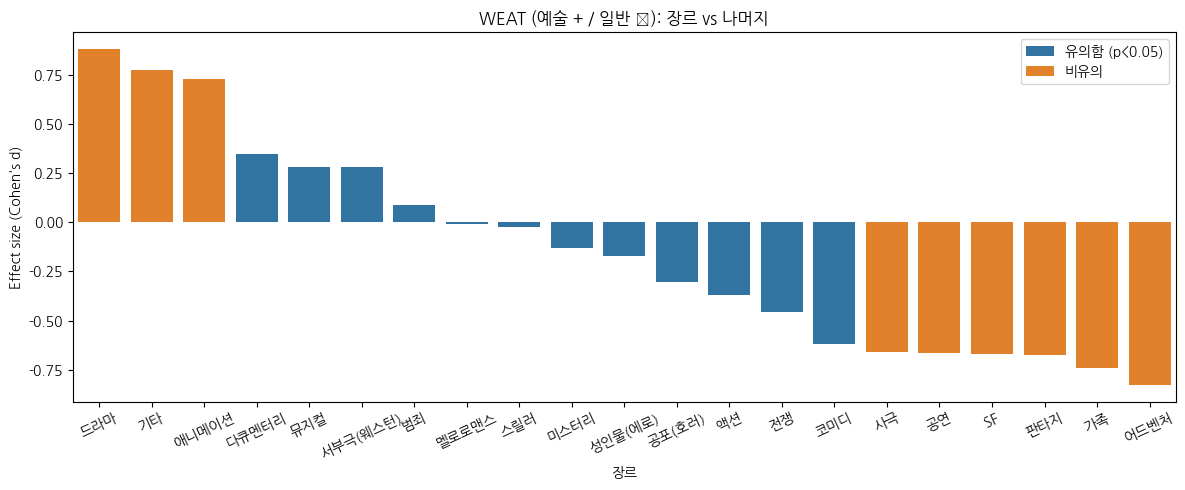

In [44]:
plt.figure(figsize=(12, 5))
ax = sns.barplot(
    data=df_weat,
    x="genre", y="weat_effect",
    hue=(df_weat["p_value"] < 0.05)
)
plt.title("WEAT (예술 + / 일반 −): 장르 vs 나머지")
plt.xlabel("장르"); plt.ylabel("Effect size (Cohen's d)")
plt.xticks(rotation=25)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["유의함 (p<0.05)", "비유의"], title="")
plt.tight_layout()
plt.show()

,genre,aff_art,aff_gen,diff
4,기타,0.539953,0.697437,-0.157484
6,드라마,0.485056,0.667986,-0.182930
15,애니메이션,0.537458,0.732403,-0.194945
5,다큐멘터리,0.605711,0.807041,-0.201330
12,서부극(웨스턴),0.501772,0.724387,-0.222615
10,범죄,0.496086,0.721301,-0.225215
8,뮤지컬,0.519695,0.745338,-0.225643
7,멜로로맨스,0.443410,0.670904,-0.227494
14,스릴러,0.402619,0.631129,-0.228509
9,미스터리,0.472825,0.703851,-0.231027


/tmp/ipython-input-3385500486.py:15: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


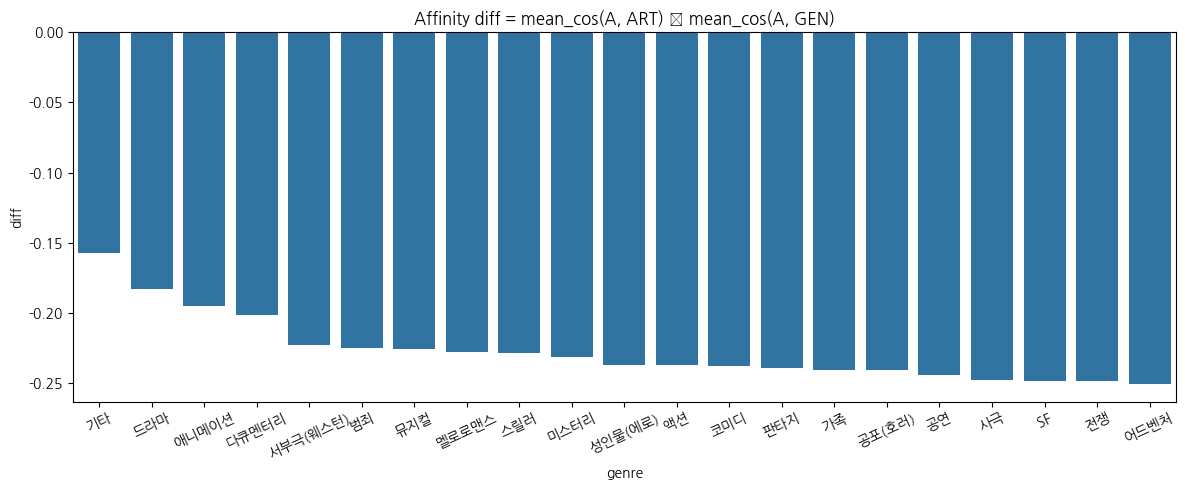

In [45]:
rows2 = []
for g in genre_name:
    A = genre_attr_vecs[g]
    aff_art = mean_cos_to_set(A, X_targets)
    aff_gen = mean_cos_to_set(A, Y_targets)
    rows2.append({"genre": g, "aff_art": aff_art, "aff_gen": aff_gen, "diff": aff_art - aff_gen})

df_aff = pd.DataFrame(rows2).sort_values("diff", ascending=False)
display(df_aff.head(10))

plt.figure(figsize=(12,5))
sns.barplot(data=df_aff, x="genre", y="diff")
plt.title("Affinity diff = mean_cos(A, ART) − mean_cos(A, GEN)")
plt.xticks(rotation=25)
plt.tight_layout(); plt.show()

In [46]:
tables = []
TOP_K = 15
for g in genre_name:
    words = genre_attributes[g]
    tmp = []
    for w in words:
        aff = word_affinity(w)
        if aff is None: continue
        a, b, d = aff
        tmp.append((w, a, b, d))
    tmp = sorted(tmp, key=lambda x: x[3], reverse=True)
    tables.append((g, tmp[:TOP_K], tmp[-TOP_K:]))

for g, top_pos, top_neg in tables:
    print(f"\n=== {g} | top +ART ===")
    for w,a,b,d in top_pos: print(f"{w:>12s} | diff={d:.3f} (art={a:.3f}, gen={b:.3f})")
    print(f"=== {g} | top +GEN ===")
    for w,a,b,d in reversed(top_neg): print(f"{w:>12s} | diff={d:.3f} (art={a:.3f}, gen={b:.3f})")



=== SF | top +ART ===
        어니스트 | diff=-0.153 (art=0.543, gen=0.696)
          가상 | diff=-0.199 (art=0.553, gen=0.752)
         핵전쟁 | diff=-0.219 (art=0.430, gen=0.649)
          시몬 | diff=-0.226 (art=0.664, gen=0.891)
          사태 | diff=-0.234 (art=0.594, gen=0.828)
          멸망 | diff=-0.234 (art=0.407, gen=0.642)
         에너지 | diff=-0.235 (art=0.630, gen=0.865)
          군단 | diff=-0.235 (art=0.609, gen=0.844)
          마토 | diff=-0.238 (art=0.611, gen=0.849)
          파견 | diff=-0.238 (art=0.599, gen=0.837)
         시스템 | diff=-0.239 (art=0.617, gen=0.856)
          운석 | diff=-0.239 (art=0.606, gen=0.845)
          위성 | diff=-0.239 (art=0.631, gen=0.870)
          인공 | diff=-0.240 (art=0.655, gen=0.894)
         클라크 | diff=-0.240 (art=0.514, gen=0.755)
=== SF | top +GEN ===
         우주인 | diff=-0.267 (art=0.553, gen=0.820)
          외부 | diff=-0.266 (art=0.482, gen=0.748)
          섹터 | diff=-0.265 (art=0.494, gen=0.759)
          케이 | diff=-0.264 (art=0.557, gen=0.822)
     

Experiment 3

In [47]:
art_seed_extra = [
    "롱테이크", "롱숏", "몽타주", "다이제시스", "미장센", "형식주의",
    "느와르", "실험영화", "독립영화", "페스티벌", "비평", "평론",
    "고다르", "베르톨루치", "타르코프스키", "오즈", "구로사와", "안토니오니",
    "아방가르드", "전위", "리얼리즘", "내러티브", "서사", "주제의식"
]


In [48]:
art_seed_total = list(set(art_seed_manual + art_seed_extra))

In [51]:
target_art_words = in_w2v(art_seed_total)
target_gen_words = in_w2v(gen_seed_manual)

A, G = set(target_art_words), set(target_gen_words)
A -= (A & G); G -= (A & G)
M = min(len(A), len(G), 40)
target_art_words = list(A)[:M]
target_gen_words = list(G)[:M]

print("ART targets:", len(target_art_words), target_art_words[:26])
print("GEN targets:", len(target_gen_words), target_gen_words[:26])

ART targets: 26 ['관조', '실험영화', '내러티브', '미학', '상징', '수상', '은유', '독립영화', '평론', '철학', '리얼리즘', '오즈', '사유', '몽타주', '베르톨루치', '고다르', '페스티벌', '조형', '서사', '느와르', '예술', '전위', '미장센', '아방가르드', '비평', '서정']
GEN targets: 26 ['흥행', '제작비', '박스오피스', '블록버스터', '코미디', '프랜차이즈', '속편', '스릴러', '카메오', '이벤트', '액션', '히어로', '대작', '캐스팅', '오락', '멜로', '빌런', '스타', '상업', '스케일', '개봉', '시리즈', '클리셰', '예고편', '마케팅', '대중성']


In [52]:
X_targets = np.array([model.wv[w] for w in target_art_words])
Y_targets = np.array([model.wv[w] for w in target_gen_words])

In [53]:
rows = []
for g in genre_name:
    A = genre_attr_vecs[g]
    B = rest_attr_vecs(g)
    if A.size == 0 or B.size == 0:
        eff, p = 0.0, 1.0
    else:
        eff, p = weat_permutation_test(X_targets, Y_targets, A, B, n_perm=2000)
    rows.append({"genre": g, "weat_effect": eff, "p_value": p})

df_weat = pd.DataFrame(rows).sort_values("weat_effect", ascending=False)
display(df_weat.head(10))


,genre,weat_effect,p_value
6,드라마,0.606694,0.026987
4,기타,0.324434,0.241379
15,애니메이션,0.272861,0.316842
7,멜로로맨스,0.216462,0.422289
14,스릴러,0.199057,0.474763
12,서부극(웨스턴),0.183585,0.539230
8,뮤지컬,0.168211,0.557221
13,성인물(에로),0.131515,0.614193
9,미스터리,0.122703,0.657171
10,범죄,0.037550,0.894053


/tmp/ipython-input-891729810.py:12: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


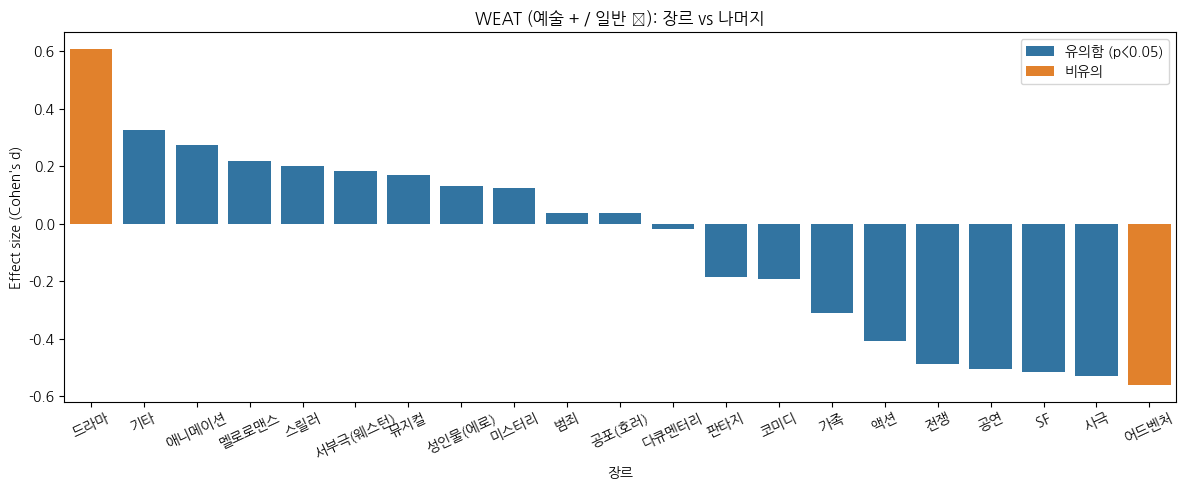

In [54]:
plt.figure(figsize=(12, 5))
ax = sns.barplot(
    data=df_weat,
    x="genre", y="weat_effect",
    hue=(df_weat["p_value"] < 0.05)
)
plt.title("WEAT (예술 + / 일반 −): 장르 vs 나머지")
plt.xlabel("장르"); plt.ylabel("Effect size (Cohen's d)")
plt.xticks(rotation=25)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["유의함 (p<0.05)", "비유의"], title="")
plt.tight_layout()
plt.show()

,genre,aff_art,aff_gen,diff
4,기타,0.510310,0.645226,-0.134915
6,드라마,0.470905,0.606352,-0.135447
14,스릴러,0.412088,0.562478,-0.150391
15,애니메이션,0.518329,0.670681,-0.152352
7,멜로로맨스,0.447500,0.600459,-0.152959
13,성인물(에로),0.450913,0.607363,-0.156449
9,미스터리,0.473489,0.634054,-0.160566
12,서부극(웨스턴),0.497405,0.658647,-0.161242
3,공포(호러),0.469520,0.632159,-0.162639
8,뮤지컬,0.513333,0.676800,-0.163467


/tmp/ipython-input-3385500486.py:15: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


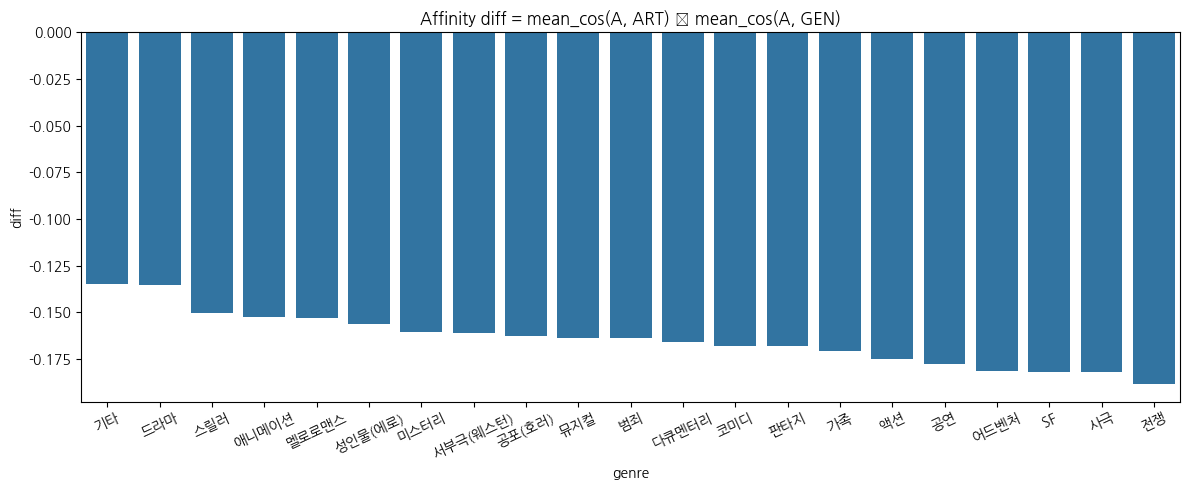

In [55]:
rows2 = []
for g in genre_name:
    A = genre_attr_vecs[g]
    aff_art = mean_cos_to_set(A, X_targets)
    aff_gen = mean_cos_to_set(A, Y_targets)
    rows2.append({"genre": g, "aff_art": aff_art, "aff_gen": aff_gen, "diff": aff_art - aff_gen})

df_aff = pd.DataFrame(rows2).sort_values("diff", ascending=False)
display(df_aff.head(10))

plt.figure(figsize=(12,5))
sns.barplot(data=df_aff, x="genre", y="diff")
plt.title("Affinity diff = mean_cos(A, ART) − mean_cos(A, GEN)")
plt.xticks(rotation=25)
plt.tight_layout(); plt.show()

In [56]:
tables = []
TOP_K = 15
for g in genre_name:
    words = genre_attributes[g]
    tmp = []
    for w in words:
        aff = word_affinity(w)
        if aff is None: continue
        a, b, d = aff
        tmp.append((w, a, b, d))
    tmp = sorted(tmp, key=lambda x: x[3], reverse=True)
    tables.append((g, tmp[:TOP_K], tmp[-TOP_K:]))

for g, top_pos, top_neg in tables:
    print(f"\n=== {g} | top +ART ===")
    for w,a,b,d in top_pos: print(f"{w:>12s} | diff={d:.3f} (art={a:.3f}, gen={b:.3f})")
    print(f"=== {g} | top +GEN ===")
    for w,a,b,d in reversed(top_neg): print(f"{w:>12s} | diff={d:.3f} (art={a:.3f}, gen={b:.3f})")


=== SF | top +ART ===
        어니스트 | diff=-0.128 (art=0.514, gen=0.642)
         핵전쟁 | diff=-0.149 (art=0.426, gen=0.575)
          가상 | diff=-0.153 (art=0.530, gen=0.683)
          멸망 | diff=-0.154 (art=0.413, gen=0.567)
         클라크 | diff=-0.162 (art=0.513, gen=0.675)
          재앙 | diff=-0.166 (art=0.481, gen=0.647)
          도니 | diff=-0.167 (art=0.468, gen=0.635)
         플래시 | diff=-0.173 (art=0.498, gen=0.671)
        알렉산더 | diff=-0.174 (art=0.523, gen=0.698)
          레아 | diff=-0.175 (art=0.521, gen=0.695)
          조종 | diff=-0.176 (art=0.527, gen=0.703)
          성냥 | diff=-0.176 (art=0.570, gen=0.746)
        괴생명체 | diff=-0.177 (art=0.516, gen=0.693)
          외부 | diff=-0.178 (art=0.491, gen=0.669)
          우즈 | diff=-0.179 (art=0.532, gen=0.711)
=== SF | top +GEN ===
          화산 | diff=-0.194 (art=0.605, gen=0.799)
         연구소 | diff=-0.194 (art=0.601, gen=0.795)
        아이언맨 | diff=-0.194 (art=0.604, gen=0.798)
         우주인 | diff=-0.193 (art=0.551, gen=0.745)
     

# 회고

# 1. 장르별 속성 집합 구성 (2단계)

초기에는 각 장르의 TF–IDF 상위 200개 단어를 선택했으나, 고유명사·지명 등이 포함되고 여러 장르에서 동일한 단어가 반복되는 문제가 있었습니다. 이를 해결하기 위해 다음 두 가지 정제 방법을 적용했습니다.


장르 간 중복 단어 제거: 다른 장르의 상위 리스트에 속하는 단어를 제외하여 각 장르만의 고유 단어를 선택했습니다.


특수성 점수 적용: 장르별 고유 단어가 부족할 경우, 해당 장르의 TF–IDF가 다른 장르 평균보다 크게 차이가 나는 단어를 추가했습니다.


이 과정을 통해 각 장르를 대표하는 약 60개의 단어 세트가 만들어졌습니다.


# 2. 목표 단어 ART와 GEN 선정 (3단계)

시드 목록을 단순히 TF–IDF로 확장한 초기 시도에서는 고유명사나 무관한 용어가 포함되어 결과가 좋지 않았습니다. 최종적으로 다음과 같이 개선했습니다.


시드 단어 수작업 선정: 영화 이론 용어(몽타주, 미장센, 형식주의), 아트하우스 감독명(고다르, 베르톨루치)과 대중 영화 클리셰(프랜차이즈, 블록버스터, 박스오피스)를 포함했습니다.


Word2Vec 기반 필터링: Word2Vec 사전에 없는 단어, ART/GEN 사이에 겹치는 단어, 라틴 문자나 숫자가 포함된 단어를 제거했습니다.


균형 맞추기: 편향을 줄이기 위해 ART와 GEN 모두 26개 용어로 동일한 크기로 맞췄습니다.


# 3. 메트릭 계산 (4단계)


Affinity diff: 장르 단어의 벡터와 ART/GEN 센트로이드 간 코사인 유사도 차이를 평균한 값입니다. 값이 음수면 장르가 전체적으로 대중(상업) 영화 어휘에 더 가깝다는 뜻입니다.


WEAT (genre vs. rest): 각 장르를 나머지 모든 장르와 비교하여 Cohen’s d 효과 크기와 p-값을 계산합니다. d≈0.20은 작은, 0.50은 중간, 0.80은 큰 효과를 의미하며 부호는 방향을 나타냅니다

.

# 4. 결과 요약

Affinity diff 그래프에서 모든 장르가 음수(≈−0.13~−0.19)를 보였습니다. 이는 전체적으로 시놉시스 언어가 예술영화보다 대중영화 어휘에 더 가깝다는 뜻입니다.


WEAT 분석은 장르를 상대적으로 비교했습니다. 드라마, 기타, 애니메이션, 멜로/로맨스, 스릴러, 서부극, 뮤지컬, 성인물, 미스터리, 범죄는 예술 쪽 편향을 보였으나 대부분 효과 크기가 작거나 유의하지 않았습니다. 반대로 전쟁, 액션, SF, 사극, 어드벤처, 가족, 코미디 등은 대중 영화와 강하게 연관되어 음의 효과 크기를 보였습니다.

| 장르                         | 방향성 (예술↑/대중↑) | 효과 강도\*       | 유의성\*\*  |
| -------------------------- | ------------- | ------------- | -------- |
| 드라마 (Drama)                | 예술 쪽          | 중간 (d≈0.6)    | 비유의      |
| 기타 (기타/Other)              | 예술 쪽          | 중간            | 비유의      |
| 애니메이션 (Animation)          | 예술 쪽          | 중간            | 유의\*\*\* |
| 멜로/로맨스 (Melodrama/Romance) | 예술 쪽          | 약–중           | 비유의      |
| 스릴러 (Thriller)             | 예술 쪽          | 약–중           | 비유의      |
| 서부극(웨스턴) (Western)         | 예술 쪽          | 약–중           | 비유의      |
| 뮤지컬 (Musical)              | 예술 쪽          | 약–중           | 유의       |
| 성인물(에로) (Erotic)           | 예술 쪽          | 약             | 비유의      |
| 미스터리 (Mystery)             | 예술 쪽          | 약             | 비유의      |
| 범죄 (Crime)                 | 예술 쪽          | 약             | 비유의      |
| 공포(호러) (Horror)            | 거의 중립         | 매우 약          | 비유의      |
| 다큐멘터리 (Documentary)        | 거의 중립         | 거의 0          | 비유의      |
| 판타지 (Fantasy)              | 대중 쪽          | 약             | 비유의      |
| 코미디 (Comedy)               | 대중 쪽          | 중간            | 유의       |
| 가족 (Family)                | 대중 쪽          | 중간            | 유의       |
| 전쟁 (War)                   | 대중 쪽          | 강 (d≈−0.5)    | 유의       |
| 액션 (Action)                | 대중 쪽          | 강             | 유의       |
| SF (Science Fiction)       | 대중 쪽          | 강             | 유의       |
| 사극 (Historical Drama)      | 대중 쪽          | 강             | 유의       |
| 어드벤처 (Adventure)           | 대중 쪽          | 매우 강 (d≈−0.6) | 비유의      |
| 공연 (Show/Performance)      | 대중 쪽          | 약–중           | 비유의      |
